2. Môi Trường "Tích Lũy Điểm" 🎯
- Mô tả:
    + Agent có 3 lựa chọn mỗi bước: (A) lấy 1 điểm, (B) lấy 2 điểm, (C) bỏ lượt.

    + Nếu chọn B quá nhiều lần, sẽ có 10% cơ hội mất hết điểm.

    + Mục tiêu: Tích lũy điểm tối đa trong 10 bước.

-  Cách triển khai:
    + state: Tổng điểm hiện tại và số lần lựa chọn action A, B, C.
    + step(action):

    + Action A: +5 điểm.
    + Action B: +20 điểm (nhưng nếu chọn nhiều lần có thể mất hết).
    + Action C: Không làm gì.
    + REINFORCE có thể học cách cân bằng giữa rủi ro và phần thưởng.

💡 Ứng dụng: Mô phỏng quyết định rủi ro trong đầu tư.

In [56]:
import numpy as np
from torch import nn
import torch
import random
from torch.distributions import Categorical

from collections import deque

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [58]:
class My_env:
    def __init__(self):
        self.state = torch.tensor(data = [0, 0, 0, 0], dtype = torch.float32)
        self.action_0_reward = 5
        self.action_1_reward = 20
        self.action_2_reward = 0

        self.minus_pt_prob = 0.1

        self.step_counter = 0
        self.max_step = 10
        self.max_score = self.max_step * max(self.action_0_reward, self.action_1_reward, self.action_2_reward)

    def reset(self):
        # Reset môi trường trở về trạng thái ban đầu và trả về quan sát đầu tiên
        self.state = torch.tensor(data = [0, 0, 0, 0], dtype = torch.float32)
        self.step_counter = 0
        return self.state
    
    def step(self, action):
        self.step_counter += 1
        self.state[action + 1] += 1

        if action == 0: # action A -> +5 points
            self.state[0] += self.action_0_reward
            reward = self.action_0_reward
        elif action == 1: # action B -> +20 pts with probs = 0.9, -all otherwise
            tmp = random.uniform(0, 1)
            if tmp <= 0.1: 
                reward = -20 #-self.state[0]
                self.state[0] = 0
            else: 
                self.state[0] += self.action_1_reward
                reward = self.action_1_reward
        elif action == 2: # action C -> +0 pts
            self.state[0] += self.action_2_reward
            reward = self.action_2_reward

        done = False
        if self.step_counter == self.max_step:
            done = True
        return self.state, reward, done, None

In [59]:
class My_policy(nn.Module):
    def __init__(self, env, n_hiddens = 5):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(4, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, 3)

    def normalize(self, state):
        state[0] /= self.env.max_score
        state[1] /= self.env.max_step
        state[2] /= self.env.max_step
        state[3] /= self.env.max_step
        return state
    
    def forward(self, state): # state: 
        state = self.normalize(state).to(device)
        h = self.fc1(state)
        output = self.fc2(h)
        return torch.softmax(output, dim = 0)

    def act(self, state):
        state = state.float().to(device)
        probs = self.forward(state).cpu()
        # [0, 1, 2]
        # probs = [0.4, 0.2, 0.4]
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [60]:
env = My_env()
policy = My_policy(env).to(device)

test_action_dis = policy(state = torch.tensor(data = [0, 0, 0, 0], dtype = torch.float32))

In [61]:
test_action_dis, torch.sum(test_action_dis)

(tensor([0.3191, 0.2671, 0.4137], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>))

In [62]:
policy.act(torch.tensor(data = [0, 0, 0, 0]))

(2, tensor(-0.8825, grad_fn=<SqueezeBackward1>))

In [63]:
from d2l import torch as d2l

In [64]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    anim = d2l.Animator(xlabel = "n_training_episodes", ylabel = "avg_score", legend = ["score"])
    scores_deque = deque(maxlen = 100)
    scores = []

    for i_episode in range(1, n_training_episodes + 1):
        saved_log_prods = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_prods.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen = max_t)
        n_steps = len(rewards)

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns) > 0 else 0)
            returns.appendleft(gamma * disc_return_t + rewards[t])

        # eps is the smallest repersentable float, which is added
        # to the standard devitation of the returns to avoid numerical instabilities
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_loss = torch.zeros(size = (1,))
        for log_prob, disc_return in zip(saved_log_prods, returns):
            policy_loss += -log_prob * disc_return
        # print(policy_loss)
        # policy_loss = torch.sum(torch.tensor(policy_loss))

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if (i_episode % print_every == 0):
            anim.add([i_episode], [np.mean(scores_deque)])
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [65]:
hyperparameters = {
    "h_size": 5,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 1000,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 0.005
}

In [66]:
env = My_env()
policy = My_policy(env).to(device)
policy_optimizer = torch.optim.Adam(policy.parameters(), lr = hyperparameters['lr'])

Episode 1000	Average Score: 161.70


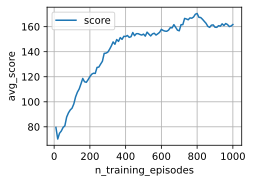

In [67]:
scores = reinforce(policy,
                   policy_optimizer,
                   hyperparameters["n_training_episodes"], 
                   hyperparameters["max_t"],
                   hyperparameters["gamma"], 
                   10)

In [68]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_reward_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info = env.step(action)
            total_reward_ep += reward

            if done:
                break
            state = new_state

        episode_rewards.append(total_reward_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

            

In [69]:
evaluate_agent(My_env(), hyperparameters["max_t"], hyperparameters["n_evaluation_episodes"], policy)

(159.605, 38.2108489175522)